# **Kaggle – DataTops®**
Tu TA ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Aspectos importantes
- Última submission:
    - Mañana: 17 de febrero a las 5pm
    - Tarde: 19 de febrero a las 5pm
- **Enlace de la competición**: https://www.kaggle.com/t/c5cc87b50c4b4770bdc8f5acbe15577d
- **Requisito**: Estar registrado en [Kaggle](https://www.kaggle.com/)

## Métrica:
El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## 1. Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bootcampviztools as bt
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import urllib.request

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle
df = pd.read_csv("./data/train.csv", index_col="laptop_ID")

### 2.1 Exploración de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [5]:
df.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


### 2.3 Definir X e y

In [6]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(912, 11)

In [7]:
y.shape

(912,)

### 2.4 Dividir X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## 3. Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [9]:
target = "Price_in_euros"

In [10]:
X_train.nunique()

Company              17
Product             408
TypeName              6
Inches               15
ScreenResolution     33
Cpu                  93
Ram                   8
Memory               33
Gpu                  84
OpSys                 9
Weight              148
dtype: int64

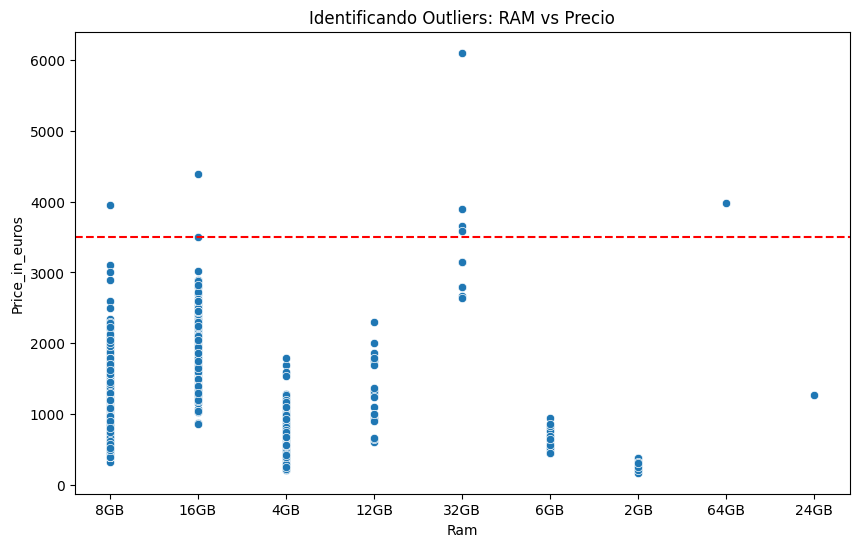

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Ram'], y=df['Price_in_euros'])
plt.axhline(y=3500, color='r', linestyle='--') # Línea de aviso
plt.title("Identificando Outliers: RAM vs Precio")
plt.show()

In [12]:
def lowercase_columns(df: pd.DataFrame):
    return df.rename(columns=str.lower)

X_train = lowercase_columns(X_train)
X_test = lowercase_columns(X_test)

In [13]:
def clean_os(df):
    # Creamos un diccionario de mapeo
    os_mapping = {
        'Windows 10': 'Windows',
        'Windows 7': 'Windows',
        'Windows 10 S': 'Windows',
        'macOS': 'Apple',
        'Mac OS X': 'Apple',
        'No OS': 'No_OS',
        'Linux': 'Linux',
        'Chrome OS': 'Other',
        'Android': 'Other'
    }
    
    # Aplicamos el mapeo
    df['opsys'] = df['opsys'].map(os_mapping)
    
    # Si hay algún valor que no estaba en el diccionario, lo marcamos como 'Other'
    df['opsys'] = df['opsys'].fillna('Other')
    
    return df

# Aplicar a train y test
X_train = clean_os(X_train)
X_test = clean_os(X_test)

In [14]:
pos_to_drop = np.where(y_train > 3500)[0]

X_train = X_train.drop(X_train.index[pos_to_drop])
y_train = y_train.drop(y_train.index[pos_to_drop])

In [15]:
def drop_columns(df: pd.DataFrame, columns: list):
    return df.drop(columns=columns, axis=1)

X_train = drop_columns(X_train, ['product'])
X_test = drop_columns(X_test, ['product'])

In [16]:
def group_companies(df):
    top_8_companies = ['Lenovo', 'Dell', 'HP', 'Asus','Acer','Toshiba','MSI','Apple']
    df['company'] = df['company'].apply(lambda x: x if x in top_8_companies else 'Other')
    return df

X_train = group_companies(X_train)
X_test = group_companies(X_test)

In [17]:
def process_weight(df):
    df['weight'].str.contains('kg').sum()
    df['weight'] = df['weight'].str.replace('kg','').astype(float)
    df.rename(columns={'weight': 'weight(kg)'}, inplace=True)
    return df
X_train = process_weight(X_train)
X_test = process_weight(X_test)


In [18]:
def extract_memory_features(df):
    # Aseguramos que trabajamos sobre una copia
    df = df.copy()
    
    # Inicializamos las columnas en 0
    df['SSD'] = 0
    df['HDD'] = 0
    df['Flash_Storage'] = 0
    df['Hybrid'] = 0

    # Limpieza básica y separación de configuraciones duales (ej: 128GB SSD + 1TB HDD)
    # Usamos una expresión regular para encontrar la cantidad y el tipo
    import re

    def parse_memory(row):
        parts = re.split(r'\+', str(row))
        for part in parts:
            # Extraer el número
            amount = re.findall(r'(\d+)', part)
            if not amount: continue
            size = float(amount[0])
            
            # Convertir TB a GB
            if 'TB' in part:
                size *= 1024
            
            # Asignar al tipo correcto
            if 'SSD' in part:
                df.at[index, 'SSD'] += size
            elif 'HDD' in part:
                df.at[index, 'HDD'] += size
            elif 'Flash Storage' in part:
                df.at[index, 'Flash_Storage'] += size
            elif 'Hybrid' in part:
                df.at[index, 'Hybrid'] += size

    for index, row in df.iterrows():
        parse_memory(row['memory'])
        
    return df.drop('memory', axis=1)

X_train = extract_memory_features(X_train)

In [19]:
def process_resolution(df):
    df["is_ips"] = df["screenresolution"].str.contains("IPS").astype(int)
    df["is_touch"] = df["screenresolution"].str.contains("Touch").astype(int)
    df["is_hd"] = df["screenresolution"].str.contains("Full HD").astype(int)

    res = df["screenresolution"].str.extract(r"(\d+)x(\d+)")
    df["res_x"] = res[0].astype(int)
    df["res_y"] = res[1].astype(int)

    df = df.drop(columns="screenresolution")
    return df

X_train = process_resolution(X_train)
X_test = process_resolution(X_test)

In [20]:
def ram(df):
    df['ram'] = df['ram'].str.replace('GB', '')
    df.rename(columns={'ram': 'ram(GB)'}, inplace=True)
    df['ram(GB)'] = df['ram(GB)'].astype(int)
    return df

X_train = ram(X_train)
X_test = ram(X_test)

In [21]:
def process_gpu(df):
    df['gpu_brand'] = df['gpu'].str.extract(r'^(\w+)')
    df = df.drop(columns="gpu", axis=1)
    return df

X_train = process_gpu(X_train)
X_test = process_gpu(X_test)

In [22]:
def process_cpu(df):
    # 1. Extraer la velocidad en GHz como número
    df['cpu_GHz'] = df['cpu'].str.extract(r'(\d+\.?\d*)GHz').astype(float)

    # 2. Categorizar el tipo de procesador
    def fetch_processor(text):
        if "Intel Core i7" in text:
            return "Intel Core i7"
        elif "Intel Core i5" in text:
            return "Intel Core i5"
        elif "Intel Core i3" in text:
            return "Intel Core i3"
        elif "Intel" in text:
            return "Other Intel Processor"
        else:
            return "AMD Processor"

    df['cpu_brand'] = df['cpu'].apply(fetch_processor)
    
    # 3. Borrar la original
    df.drop(columns=['cpu'], inplace=True)
    return df

X_train = process_cpu(X_train)
X_test = process_cpu(X_test)

In [23]:
X_train.head()

,company,typename,inches,ram(GB),opsys,weight(kg),SSD,HDD,Flash_Storage,Hybrid,is_ips,is_touch,is_hd,res_x,res_y,gpu_brand,cpu_GHz,cpu_brand
laptop_ID,,,,,,,,,,,,,,,,,,
1118,HP,Workstation,17.3,8,Windows,3.00,0,1024,0,0,1,0,1,1920,1080,AMD,2.6,Intel Core i7
153,Dell,Gaming,15.6,16,Windows,2.56,512,0,0,0,0,0,1,1920,1080,Nvidia,2.8,Intel Core i7
275,Apple,Ultrabook,13.3,8,Apple,1.37,512,0,0,0,1,0,0,2560,1600,Intel,2.9,Intel Core i5
1100,HP,Notebook,14.0,4,Windows,1.54,0,500,0,0,0,0,1,1920,1080,Intel,2.3,Intel Core i5
131,Dell,Notebook,17.3,16,Windows,2.80,256,2048,0,0,0,0,1,1920,1080,AMD,1.8,Intel Core i7


## Features priority

In [24]:
for col in X_train.columns:
    print(f"\n🔹 Columna: {col}")
    print(X_train[col].value_counts(dropna=False))


🔹 Columna: company
company
Lenovo     162
Dell       157
HP         154
Asus        99
Acer        55
Toshiba     31
MSI         30
Other       23
Apple       13
Name: count, dtype: int64

🔹 Columna: typename
typename
Notebook              412
Ultrabook             113
Gaming                109
2 in 1 Convertible     62
Netbook                16
Workstation            12
Name: count, dtype: int64

🔹 Columna: inches
inches
15.6    362
14.0    115
13.3     99
17.3     90
12.5     21
11.6     20
12.0      3
13.5      3
12.3      2
15.4      2
15.0      2
13.9      2
10.1      1
14.1      1
11.3      1
Name: count, dtype: int64

🔹 Columna: ram(GB)
ram(GB)
8     340
4     217
16    111
6      20
12     18
2      15
32      3
Name: count, dtype: int64

🔹 Columna: opsys
opsys
Windows    620
No_OS       39
Linux       37
Other       15
Apple       13
Name: count, dtype: int64

🔹 Columna: weight(kg)
weight(kg)
2.20    76
2.10    33
2.00    28
2.40    25
2.50    24
        ..
2.16     1
0.91   

In [25]:
X_train.nunique()

company            9
typename           6
inches            15
ram(GB)            7
opsys              5
weight(kg)       139
SSD               11
HDD                5
Flash_Storage      7
Hybrid             3
is_ips             2
is_touch           2
is_hd              2
res_x             11
res_y              9
gpu_brand          3
cpu_GHz           22
cpu_brand          5
dtype: int64

In [26]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [27]:
X_train

,company,typename,inches,ram(GB),opsys,weight(kg),SSD,HDD,Flash_Storage,Hybrid,is_ips,is_touch,is_hd,res_x,res_y,gpu_brand,cpu_GHz,cpu_brand
laptop_ID,,,,,,,,,,,,,,,,,,
1118,HP,Workstation,17.3,8,Windows,3.00,0,1024,0,0,1,0,1,1920,1080,AMD,2.6,Intel Core i7
153,Dell,Gaming,15.6,16,Windows,2.56,512,0,0,0,0,0,1,1920,1080,Nvidia,2.8,Intel Core i7
275,Apple,Ultrabook,13.3,8,Apple,1.37,512,0,0,0,1,0,0,2560,1600,Intel,2.9,Intel Core i5
1100,HP,Notebook,14.0,4,Windows,1.54,0,500,0,0,0,0,1,1920,1080,Intel,2.3,Intel Core i5
131,Dell,Notebook,17.3,16,Windows,2.80,256,2048,0,0,0,0,1,1920,1080,AMD,1.8,Intel Core i7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,HP,Notebook,14.0,8,Windows,1.94,0,2048,0,0,0,0,0,1366,768,Intel,1.6,Other Intel Processor
996,Lenovo,Notebook,15.6,6,Windows,2.20,256,0,0,0,0,0,1,1920,1080,AMD,3.6,AMD Processor
770,Dell,Ultrabook,12.5,16,Windows,1.18,256,0,0,0,0,0,1,1920,1080,Intel,2.8,Intel Core i7


In [28]:
y_train = y_train.loc[X_train.index]

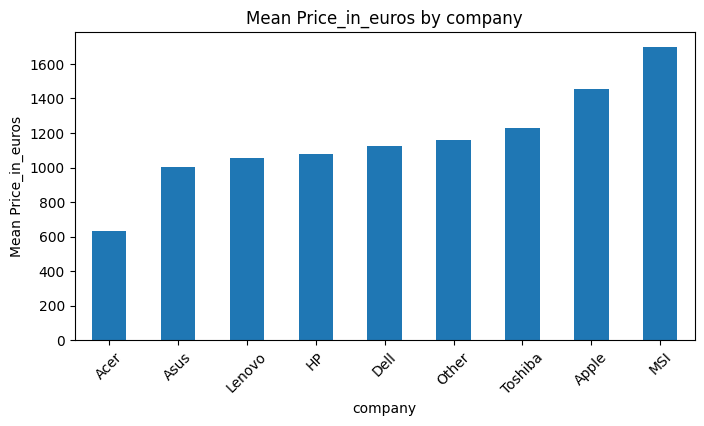

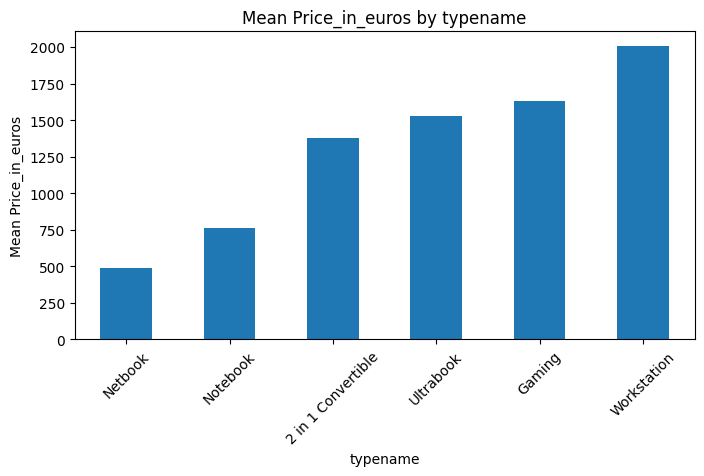

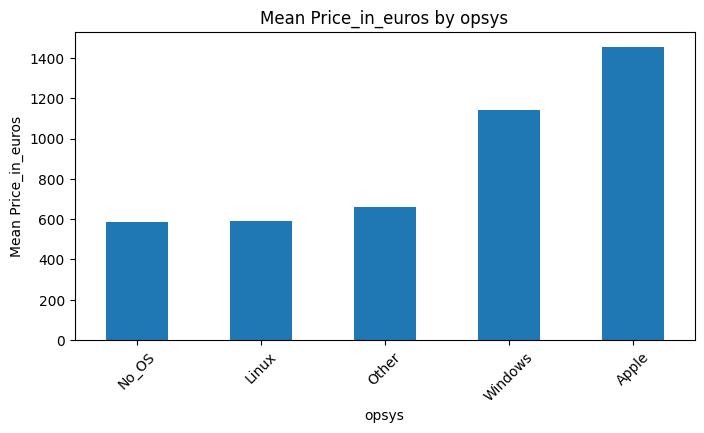

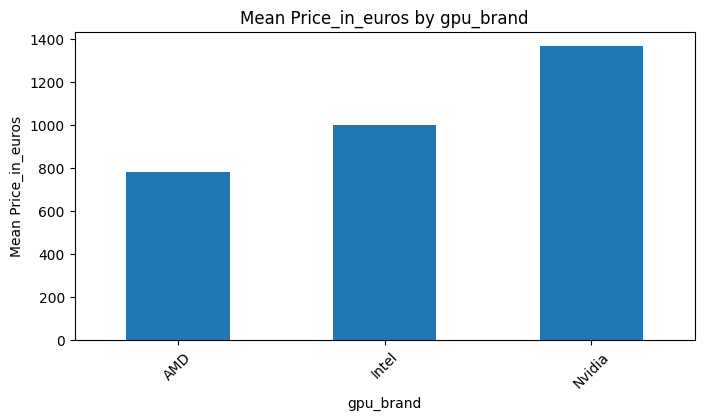

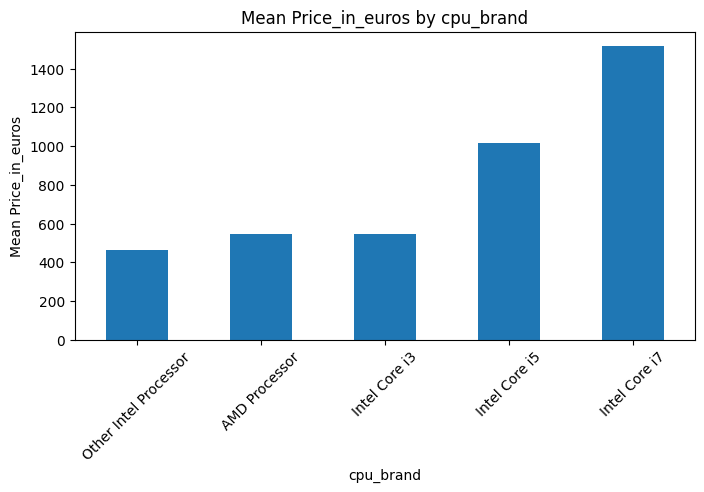

In [29]:
merge = X_train.copy()
merge = X_train.join(y_train)

for col in cat_cols:
    stats = merge.groupby(col)[target].mean().sort_values()

    plt.figure(figsize=(8,4))
    stats.plot(kind="bar")
    plt.title(f"Mean {target} by {col}")
    plt.ylabel(f"Mean {target}")
    plt.xticks(rotation=45)
    plt.show()

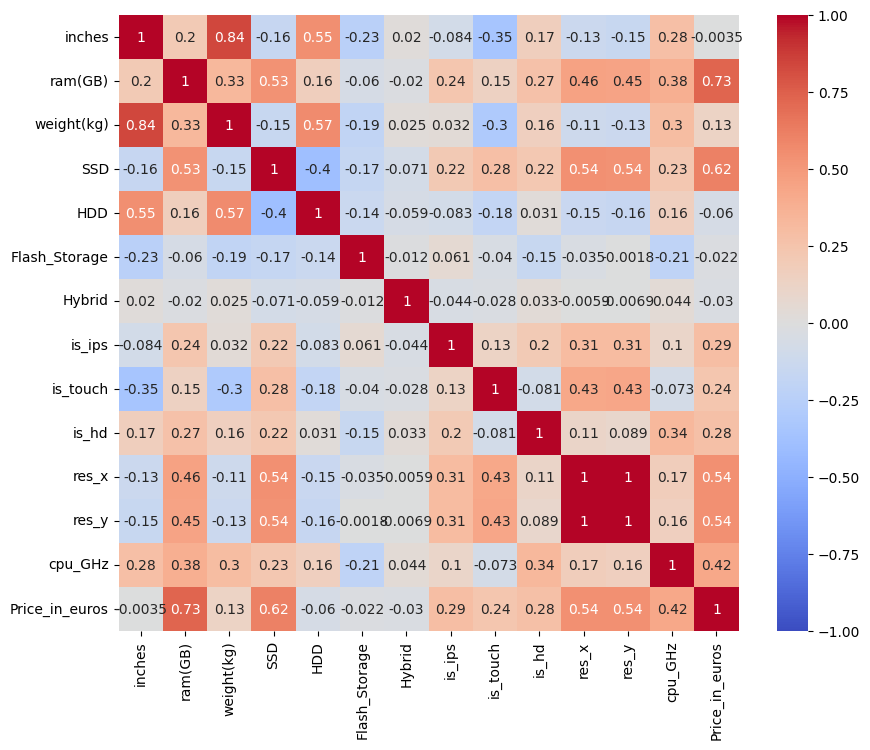

In [30]:
# crear DataFrame temporal con target
df_corr = pd.concat([X_train[num_cols], y_train], axis=1)

# calcular correlación
corr_matrix = df_corr.corr()

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [31]:
num_cols

['inches',
 'ram(GB)',
 'weight(kg)',
 'SSD',
 'HDD',
 'Flash_Storage',
 'Hybrid',
 'is_ips',
 'is_touch',
 'is_hd',
 'res_x',
 'res_y',
 'cpu_GHz']

In [32]:
features_sets = {
    "set_1": ["ram(GB)", "SSD", "res_x"],
    "set_2": ["ram(GB)", "SSD", "res_x","res_y"],
    "set_3": ["ram(GB)", "res_x", "is_ips","is_hd","is_touch","cpu_GHz"],
    "set_4": ["ram(GB)", "res_x", "is_ips","is_hd","is_touch","cpu_GHz",'res_x','res_y'],
    "set_5": ["ram(GB)", "res_x", "is_ips","is_hd","is_touch","cpu_GHz",'res_x','res_y',"inches"],
    "set_6": ["ram(GB)", "res_x", "is_ips","is_hd","is_touch","cpu_GHz",'res_x','res_y','weight(kg)'],
    "set_7": ['inches','ram(GB)','weight(kg)','SSD','HDD','Flash_Storage','Hybrid','is_ips','is_touch','is_hd','cpu_GHz'],
    "set_8": num_cols
}

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 1118 to 418
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   company        724 non-null    object 
 1   typename       724 non-null    object 
 2   inches         724 non-null    float64
 3   ram(GB)        724 non-null    int64  
 4   opsys          724 non-null    object 
 5   weight(kg)     724 non-null    float64
 6   SSD            724 non-null    int64  
 7   HDD            724 non-null    int64  
 8   Flash_Storage  724 non-null    int64  
 9   Hybrid         724 non-null    int64  
 10  is_ips         724 non-null    int64  
 11  is_touch       724 non-null    int64  
 12  is_hd          724 non-null    int64  
 13  res_x          724 non-null    int64  
 14  res_y          724 non-null    int64  
 15  gpu_brand      724 non-null    object 
 16  cpu_GHz        724 non-null    float64
 17  cpu_brand      724 non-null    object 
dtypes: float64(3

In [34]:
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [35]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [36]:


scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

-----------------------------------------------------------------------------------------------------------------

## 4. Modelado

### 4.1 Baseline de modelos


In [37]:
from lightgbm import LGBMRegressor

modelos = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=10),            # L2: Penaliza coeficientes altos (evita overfitting)
    "Lasso": Lasso(alpha=0.1),            # L1: Puede eliminar variables poco útiles (las hace 0)
    "Huber": HuberRegressor(epsilon=1.35),
    "ElasticNet": ElasticNet(alpha = 0.02, l1_ratio=1),  # Mezcla Ridge y Lasso
    "DTR": DecisionTreeRegressor(random_state= 42),     
    "RandomForest": RandomForestRegressor(random_state= 42),
    "GBR": GradientBoostingRegressor(random_state= 42),
    "XGB": XGBRegressor(random_state= 42),
    "LHBM": LGBMRegressor(random_state= 42,verbose=-100)
}

In [38]:
cat_cols_dum = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [39]:
resultados = []

for set_nombre, num_cols_set in features_sets.items():
    print(f"Probando {set_nombre}...")
    
    columnas_finales = num_cols_set + cat_cols_dum
    X_subset = X_train[columnas_finales].copy()
        
    for model_nombre, modelo in modelos.items():
        # Elegimos el set de datos según el modelo
        if model_nombre in ["Linear", "Ridge", "Lasso", "Huber", "ElasticNet", "SVR"]:
            data = X_train_scaled
        else:
            data = X_train # Árboles y Boosting no necesitan escalado
            
        # Ejecutamos Cross Validation
        # Usamos neg_mean_squared_error
        mse_scores = cross_val_score(modelo, data, y_train, cv=3, scoring="neg_mean_squared_error")
        
        # Calculamos el RMSE medio (Raíz del MSE positivo)
        rmse_medio = np.sqrt(-np.mean(mse_scores))
        
        # Guardamos la info
        resultados.append({
            "Set": set_nombre,
            "Modelo": model_nombre,
            "RMSE": rmse_medio
        })

# 3. Visualizar y encontrar el ganador
df_resultados = pd.DataFrame(resultados).sort_values(by="RMSE")

print("\n--- TOP 5 MEJORES COMBINACIONES ---")
print(df_resultados.head(5))

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']} con el {ganador['Set']} (RMSE: {ganador['RMSE']:.2f})")

Probando set_1...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_2...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_3...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_4...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_5...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_6...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_7...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Probando set_8...


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 1.927e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+06, tolerance: 1.791e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t


--- TOP 5 MEJORES COMBINACIONES ---
      Set Modelo        RMSE
8   set_1    XGB  261.807995
18  set_2    XGB  261.807995
28  set_3    XGB  261.807995
38  set_4    XGB  261.807995
48  set_5    XGB  261.807995

🏆 GANADOR: XGB con el set_1 (RMSE: 261.81)


In [40]:
# Definimos las columnas que queremos conservar
set_1 = ["ram(GB)", "SSD", "res_x"]

# 2. Identificamos las columnas numéricas que queremos ELIMINAR
# (Todas las num_cols que NO están en set_1)
cols_to_drop = [c for c in num_cols if c not in set_1]

# 3. Limpiamos X_train (y X_test si lo tienes)
X_train_subset = X_train.drop(columns=cols_to_drop)
X_test_subset = X_test.drop(columns=cols_to_drop)

In [41]:
X_train_subset

,ram(GB),SSD,res_x,company_Apple,company_Asus,company_Dell,company_HP,company_Lenovo,company_MSI,company_Other,...,opsys_Linux,opsys_No_OS,opsys_Other,opsys_Windows,gpu_brand_Intel,gpu_brand_Nvidia,cpu_brand_Intel Core i3,cpu_brand_Intel Core i5,cpu_brand_Intel Core i7,cpu_brand_Other Intel Processor
laptop_ID,,,,,,,,,,,,,,,,,,,,,
1118,8,0,1920,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
153,16,512,1920,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
275,8,512,2560,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1100,4,0,1920,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,True,False,False
131,16,256,1920,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,8,0,1366,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,False,False,True
996,6,256,1920,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
770,16,256,1920,False,False,True,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False


### 4.3 Optimización 

In [42]:
metricas_optimizadas = {}

In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np

def hyperopt_train_test(params):
    # Los parámetros de Hyperopt a veces vienen como float, 
    # pero XGBoost necesita que algunos sean int.
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    model = XGBRegressor(**params, random_state=42)
    
    # Usamos neg_root_mean_squared_error
    score = cross_val_score(model, X_train_subset, y_train, 
                            cv=5, 
                            scoring="neg_root_mean_squared_error").mean()
    
    # Devolvemos el RMSE positivo (ej: 385.2)
    return -score

def f(params):
    rmse = hyperopt_train_test(params)
    return {'loss': rmse, 'status': STATUS_OK}

# Espacio de búsqueda agresivo para bajar de 423
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 3000, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 20), # Regularización L1
    'reg_lambda': hp.uniform('reg_lambda', 0.5, 20) # Regularización L2
}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=150, trials=trials)

print("Mejores parámetros:", best)
print("Mejor RMSE alcanzado:", trials.best_trial['result']['loss'])

100%|██████████| 150/150 [38:26<00:00, 15.38s/trial, best loss: 281.93169683365136]
Mejores parámetros: {'colsample_bytree': np.float64(0.5293929698555763), 'learning_rate': np.float64(0.017940446320408164), 'max_depth': np.float64(6.0), 'n_estimators': np.float64(2523.0), 'reg_alpha': np.float64(14.478820309625512), 'reg_lambda': np.float64(13.97350430413767), 'subsample': np.float64(0.9996898367812164)}
Mejor RMSE alcanzado: 281.93169683365136


In [44]:
best

{'colsample_bytree': np.float64(0.5293929698555763),
 'learning_rate': np.float64(0.017940446320408164),
 'max_depth': np.float64(6.0),
 'n_estimators': np.float64(2523.0),
 'reg_alpha': np.float64(14.478820309625512),
 'reg_lambda': np.float64(13.97350430413767),
 'subsample': np.float64(0.9996898367812164)}

In [45]:
model_bayes = XGBRegressor(n_estimators=int(best['n_estimators']),
                           max_depth=int(best['max_depth']),
                           learning_rate=best['learning_rate'],
                           subsample=best['subsample'],
                           colsample_bytree=best['colsample_bytree'],
                           reg_alpha=best['reg_alpha'],
                           reg_lambda=best['reg_lambda'],
                           random_state = 42
)
# Ahora ya no dará error
model_bayes.fit(X_train_subset, y_train)

# Evaluación
# Esto te devuelve, por ejemplo: [-415.2, -420.5, -418.1]
rmse_negativo = cross_val_score(model_bayes, data, y_train, cv=3, scoring="neg_root_mean_squared_error")

# Lo pasas a positivo para leerlo bien
rmse_real = -rmse_negativo.mean()
print(f"Tu RMSE actual es: {rmse_real}")

Tu RMSE actual es: 246.276313403302


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

## 1. Carga los datos de `test.csv` para predecir.


In [46]:
X_pred = pd.read_csv("./data/test.csv")
X_pred.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1,1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
2,1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
3,1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
4,1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [47]:
X_pred.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
386,820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
387,948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
388,483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
389,1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
390,421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [48]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         391 non-null    int64  
 1   Company           391 non-null    object 
 2   Product           391 non-null    object 
 3   TypeName          391 non-null    object 
 4   Inches            391 non-null    float64
 5   ScreenResolution  391 non-null    object 
 6   Cpu               391 non-null    object 
 7   Ram               391 non-null    object 
 8   Memory            391 non-null    object 
 9   Gpu               391 non-null    object 
 10  OpSys             391 non-null    object 
 11  Weight            391 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 36.8+ KB


 ## 2. Replicar el procesado para ``test.csv``

In [49]:
X_pred

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1,1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
2,1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
3,1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
4,1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg
...,...,...,...,...,...,...,...,...,...,...,...,...
386,820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
387,948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
388,483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
389,1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg


In [50]:
X_pred = lowercase_columns(X_pred)
X_pred = clean_os(X_pred)
X_pred = drop_columns(X_pred, ['product'])
X_pred = process_weight(X_pred)
X_pred = extract_memory_features(X_pred)
X_pred = process_resolution(X_pred)
X_pred = ram(X_pred)
X_pred = process_gpu(X_pred)
X_pred = process_cpu(X_pred)
X_pred = pd.get_dummies(X_pred, columns=cat_cols, drop_first=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=0)
X_pred_subset = X_pred.drop(columns=cols_to_drop)


In [51]:
X_pred_subset

,ram(GB),SSD,res_x,company_Apple,company_Asus,company_Dell,company_HP,company_Lenovo,company_MSI,company_Other,...,opsys_Linux,opsys_No_OS,opsys_Other,opsys_Windows,gpu_brand_Intel,gpu_brand_Nvidia,cpu_brand_Intel Core i3,cpu_brand_Intel Core i5,cpu_brand_Intel Core i7,cpu_brand_Other Intel Processor
0,16,512,1920,False,False,False,False,True,False,0,...,False,True,False,False,False,True,False,False,True,False
1,4,0,1366,False,False,False,False,False,False,0,...,True,False,False,False,True,False,False,False,False,True
2,4,0,1366,False,False,False,False,True,False,0,...,False,True,False,False,True,False,True,False,False,False
3,8,256,1920,False,False,True,False,False,False,0,...,False,False,False,True,True,False,False,True,False,False
4,4,256,1920,False,False,False,True,False,False,0,...,False,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,16,512,1920,False,False,False,False,False,True,0,...,False,False,False,True,False,True,False,False,True,False
387,4,128,1920,False,False,False,False,False,False,0,...,False,False,False,True,True,False,False,True,False,False
388,8,256,1920,False,False,True,False,False,False,0,...,False,False,False,True,False,True,False,False,True,False
389,4,0,1366,False,False,False,True,False,False,0,...,False,False,False,True,True,False,False,True,False,False


In [53]:
predictions_submit = model_bayes.predict(X_pred_subset)

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`.

In [54]:
sample = pd.read_csv("data/sample_submission.csv")

In [55]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [56]:
sample.shape

(391, 2)

In [57]:
assert len(X_pred) == len(sample)
assert (X_pred.index == sample.index).all()

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [58]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": sample.laptop_ID , "Price_in_euros" : predictions_submit})

In [59]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1304.356079
1,1281,284.628082
2,1168,391.541290
3,1231,1233.183472
4,1020,998.989197


In [60]:
submission.shape

(391, 2)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [61]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.

    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.

    Si no, LEE EL MENSAJE Y HAZLE CASO.

    Si aún no:
    - apaga tu ordenador,
    - date una vuelta,
    - enciendelo otra vez,
    - abre este notebook y
    - leelo todo de nuevo.
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")
                img = Image.open("gfg.png")
                img.show()
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [62]:
chequeador(submission)

You're ready to submit!
